In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

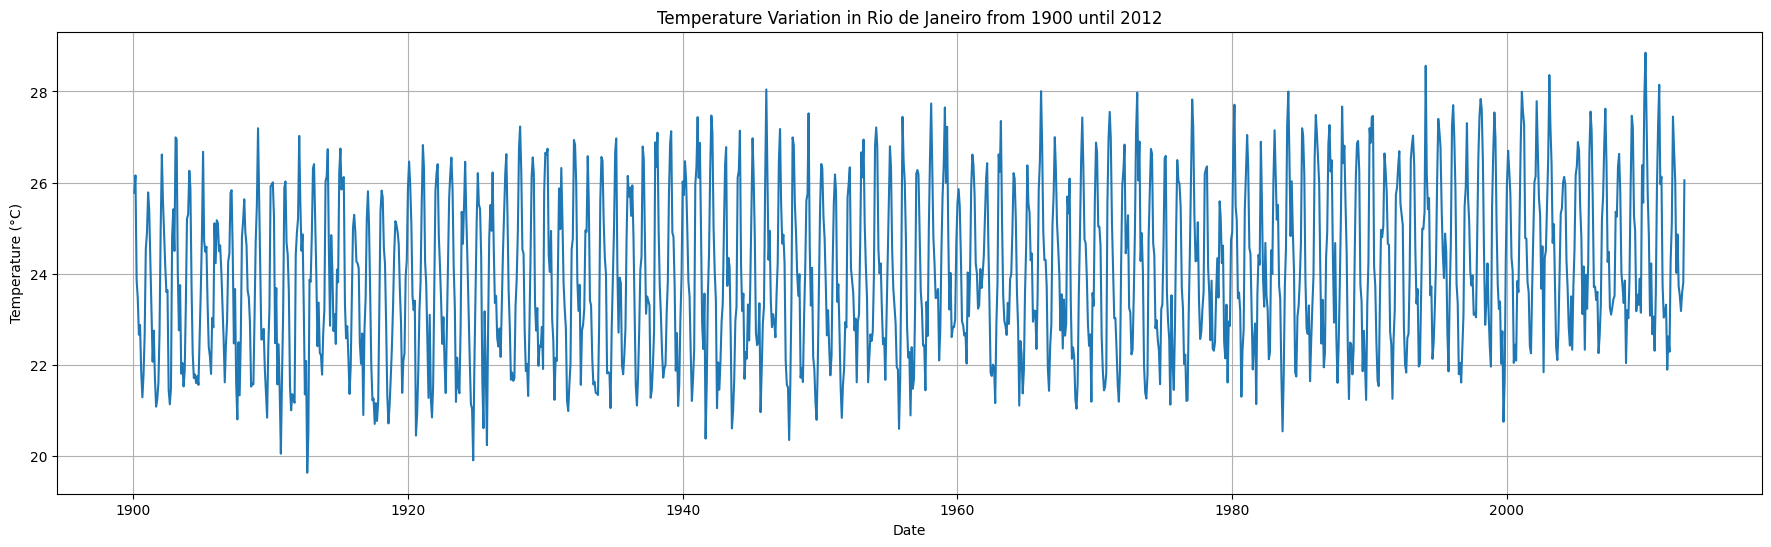

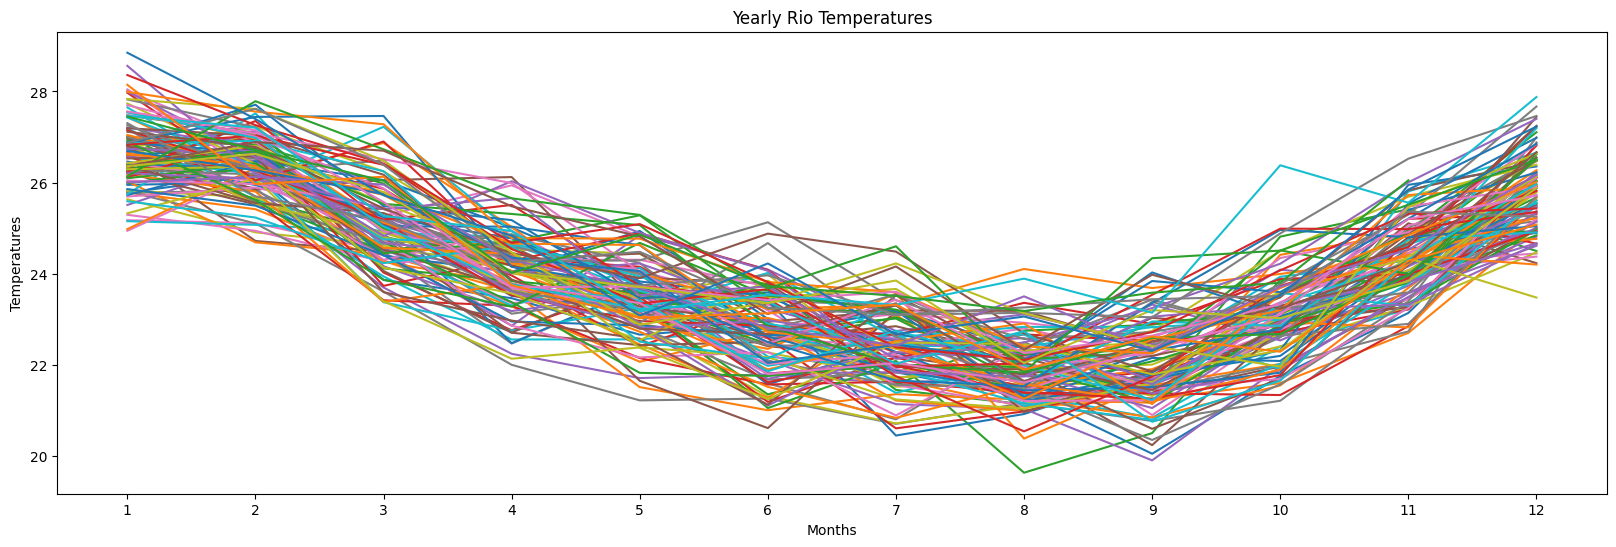

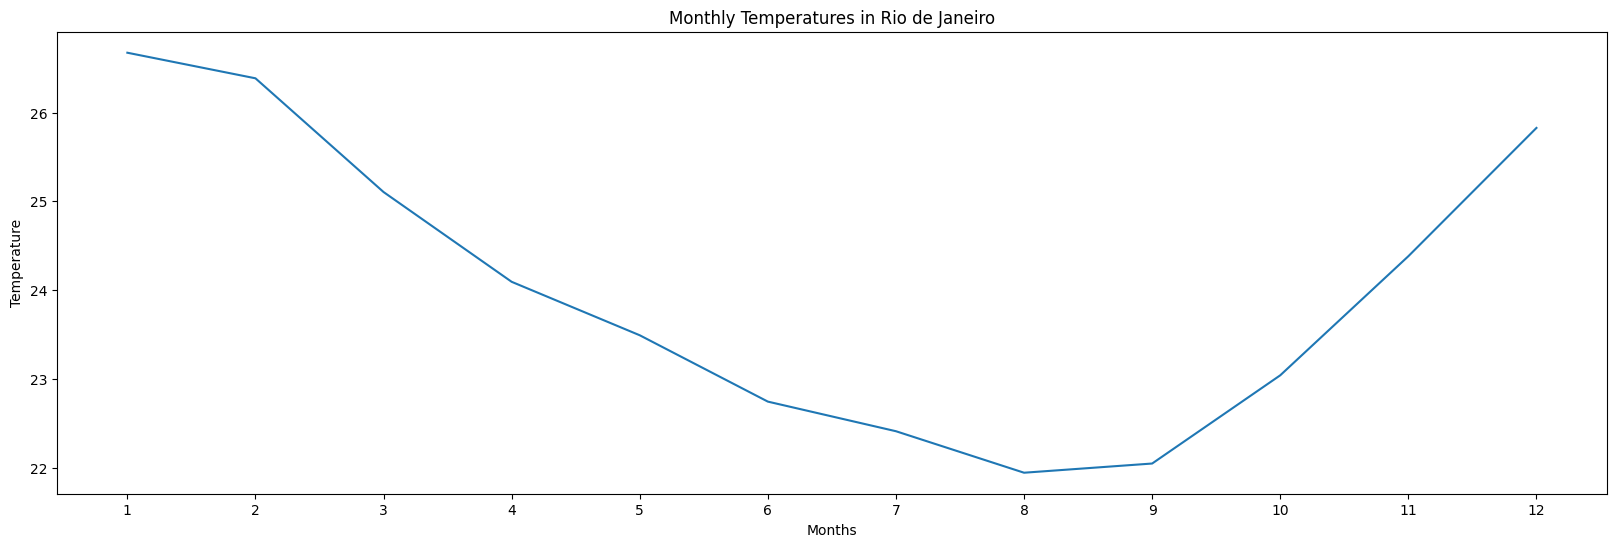

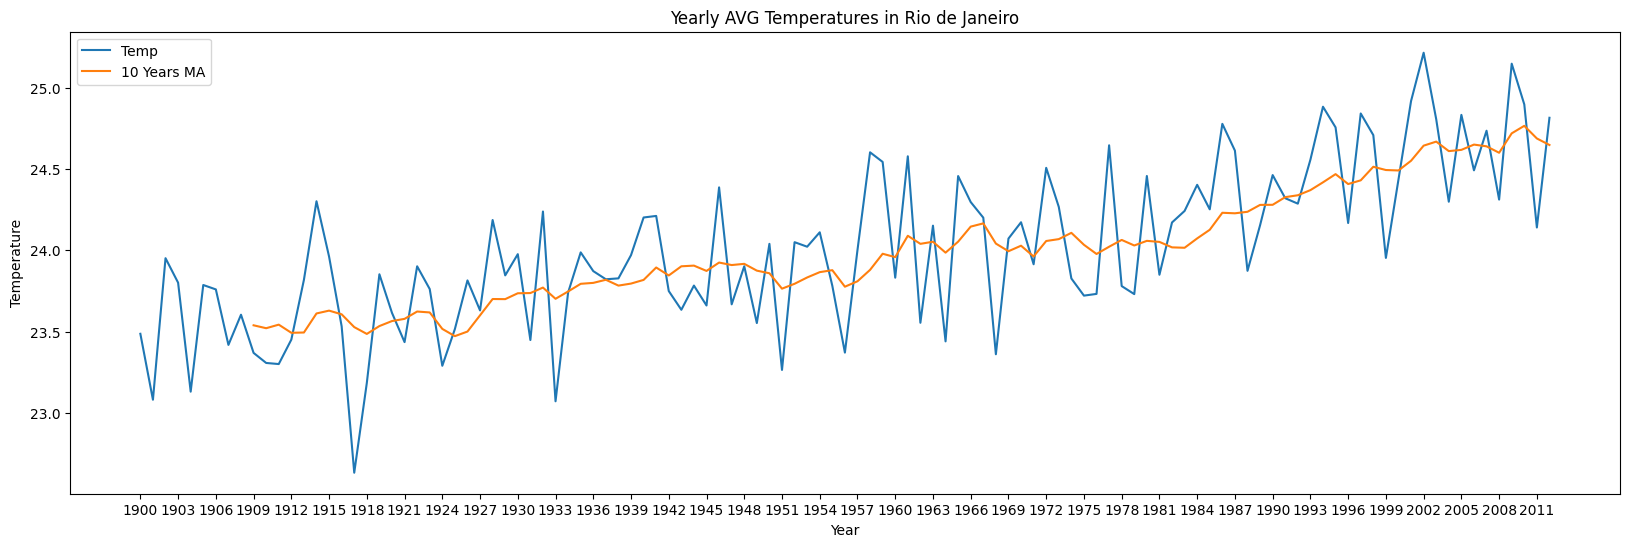

In [34]:
# Load the data
cities = pd.read_csv('/content/drive/MyDrive/climate forcasting/GlobalLandTemperaturesByCity.csv')

# Filter data for Rio de Janeiro
rio = cities[cities['City'] == 'Rio De Janeiro'][['dt', 'AverageTemperature']]

# Rename columns and set 'Date' as index
rio.columns = ['Date', 'Temp']
rio['Date'] = pd.to_datetime(rio['Date'])
rio.set_index('Date', inplace=True)

# Filter data for 1900 until 2012
rio = rio.loc['1900':'2012']

# Resample to monthly frequency and fill missing values with backward fill
rio = rio.asfreq('M', method='bfill')

# Plot temperature variation from 1900 to 2012
plt.figure(figsize=(22, 6))
sns.lineplot(data=rio, x=rio.index, y='Temp')
plt.title('Temperature Variation in Rio de Janeiro from 1900 until 2012')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Calculate monthly average temperatures for each year
rio['Month'] = rio.index.month
rio['Year'] = rio.index.year
pivot = pd.pivot_table(rio, values='Temp', index='Month', columns='Year', aggfunc='mean')

# Plot yearly Rio temperatures
pivot.plot(figsize=(20, 6))
plt.title('Yearly Rio Temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks(range(1, 13))
plt.legend().remove()
plt.show()

# Calculate monthly average temperatures across all years
monthly_seasonality = pivot.mean(axis=1)

# Plot monthly temperatures in Rio de Janeiro
monthly_seasonality.plot(figsize=(20, 6))
plt.title('Monthly Temperatures in Rio de Janeiro')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks(range(1, 13))
plt.show()

# Calculate yearly average temperatures and add 10-year moving average
year_avg = pd.pivot_table(rio, values='Temp', index='Year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()

# Plot yearly average temperatures with 10-year moving average
year_avg[['Temp', '10 Years MA']].plot(figsize=(20, 6))
plt.title('Yearly AVG Temperatures in Rio de Janeiro')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.xticks(range(1900, 2012, 3))  # Show every 3 years for better readability
plt.show()

In [35]:
# Create a copy of the DataFrame containing temperature data for Rio de Janeiro
train = rio[:-60].copy()  # Selecting all data except the last 60 months for training
val = rio[-60:-12].copy()  # Selecting the last 60-12=48 months for validation
test = rio[-12:].copy()  # Selecting the last 12 months for testing

In [36]:
# Calculate the baseline forecast by shifting the temperature values by one time step
baseline = val['Temp'].shift()

# Remove the NaN values resulting from the shift operation
baseline.dropna(inplace=True)
baseline.head()

Date
2008-01-31    25.257
2008-02-29    26.362
2008-03-31    26.631
2008-04-30    25.793
2008-05-31    24.031
Freq: M, Name: Temp, dtype: float64

In [37]:
# Define a function to calculate RMSE
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Calculate the RMSE of the baseline forecast compared to the actual temperatures in the validation set
rmse_base = measure_rmse(val.iloc[1:, 0], baseline)

# Print the RMSE of the baseline forecast
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base, 4)} celsius degrees')


The RMSE of the baseline that we will try to diminish is 1.3329 celsius degrees


In [38]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"

    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Rio de Janeiro Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()

    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] =value.round(4)


        print(adftest)

    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -3.6875
p-value                           0.0043
Lags Used                        23.0000
Number of Observations Used    1271.0000
Critical Value (1%)              -3.4355
dtype: float64
Test Statistic                   -3.6875
p-value                           0.0043
Lags Used                        23.0000
Number of Observations Used    1271.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
dtype: float64
Test Statistic                   -3.6875
p-value                           0.0043
Lags Used                        23.0000
Number of Observations Used    1271.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


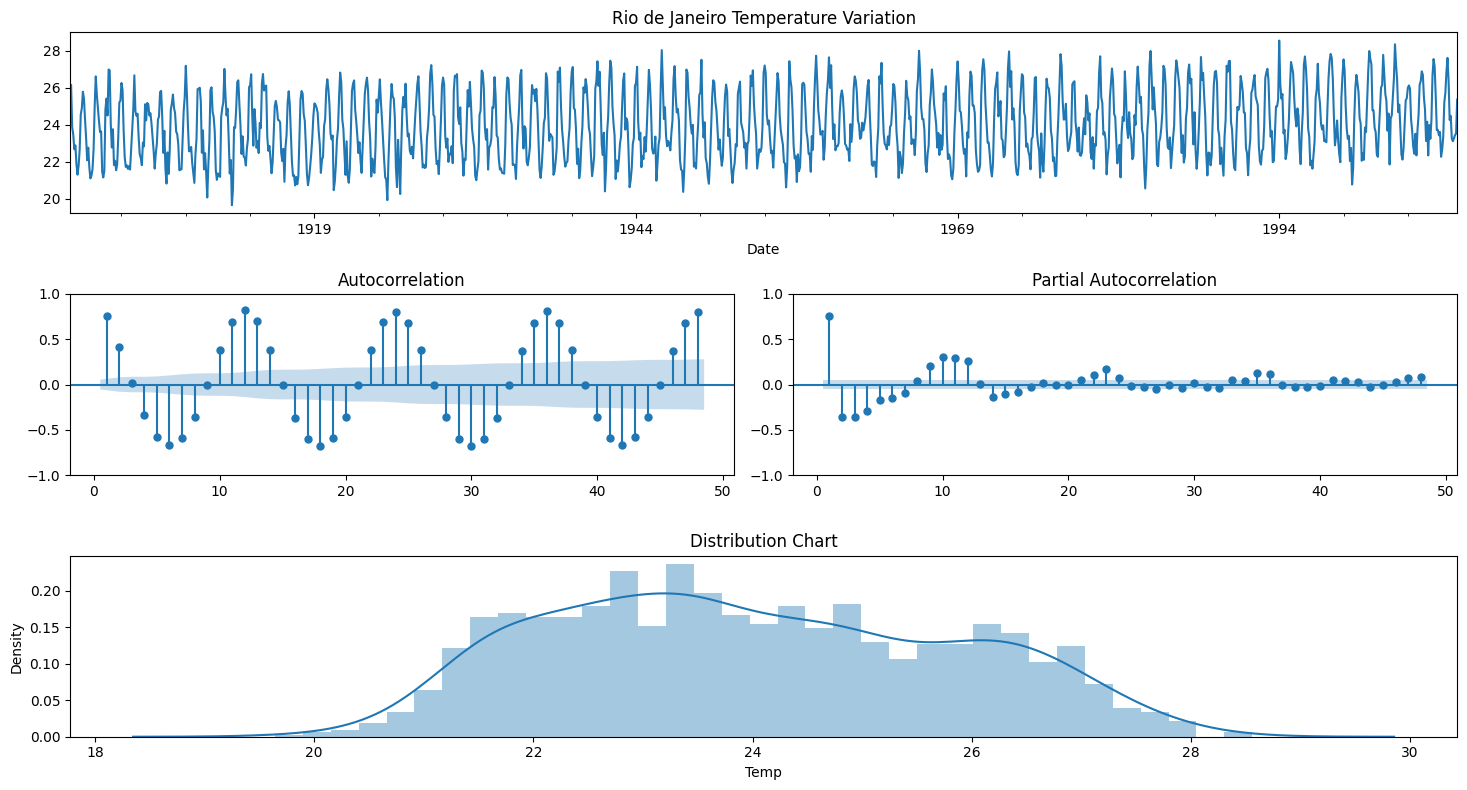

In [9]:
check_stationarity(train['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -13.4615
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1259.0000
Critical Value (1%)              -3.4356
dtype: float64
Test Statistic                  -13.4615
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1259.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
dtype: float64
Test Statistic                  -13.4615
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1259.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


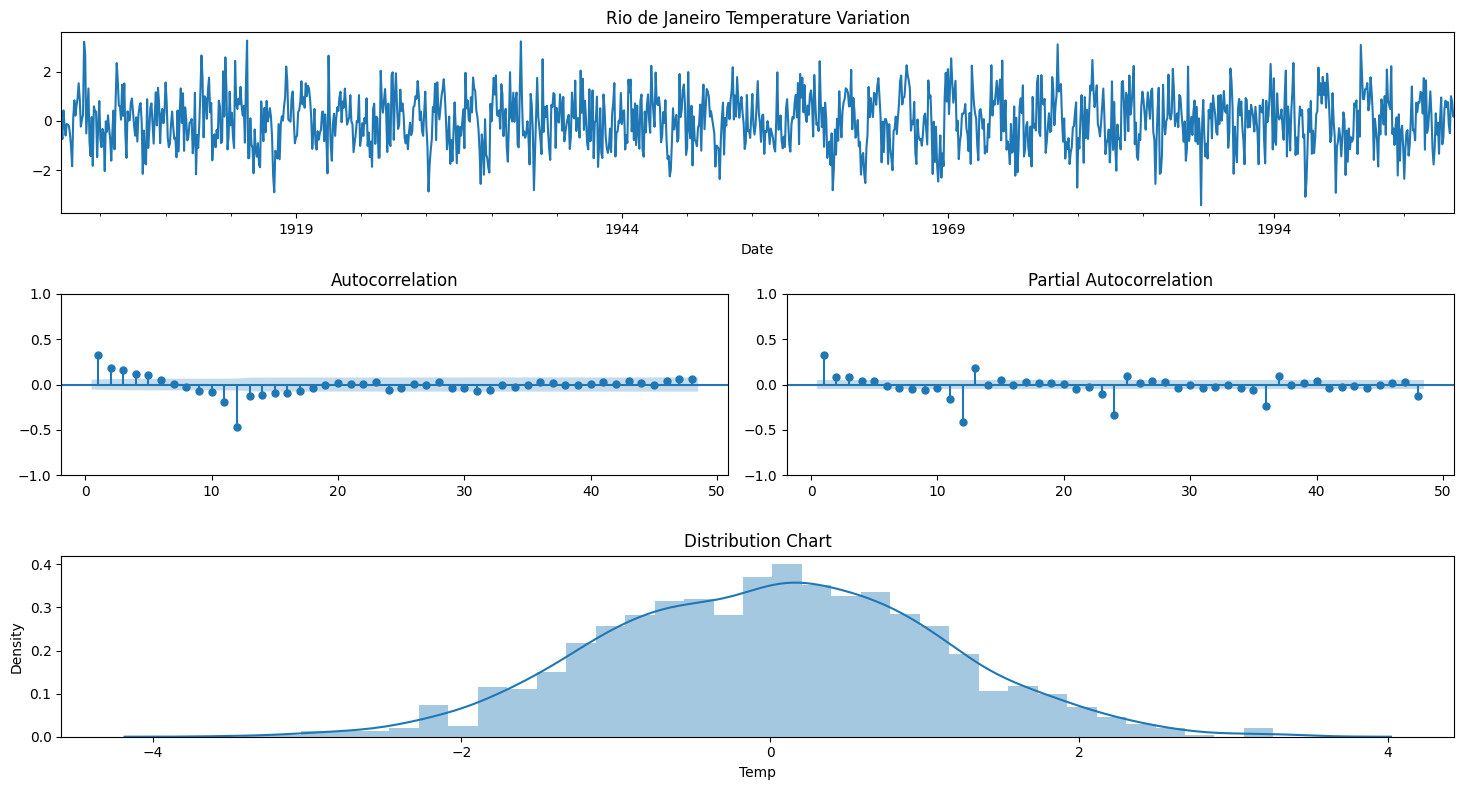

In [39]:
check_stationarity(train['Temp'].diff(12).dropna())

In [40]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()

    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])

    return prediction

In [41]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [42]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")
val['Error'] = val['Temp'] - val['Pred']

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.7948 celsius degrees
It's a decrease of -40.37% in the RMSE


In [43]:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31    25.780
1900-02-28    26.160
1900-03-31    23.868
1900-04-30    23.467
1900-05-31    22.667
Freq: M, Name: Temp, dtype: float64

In [44]:
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [45]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

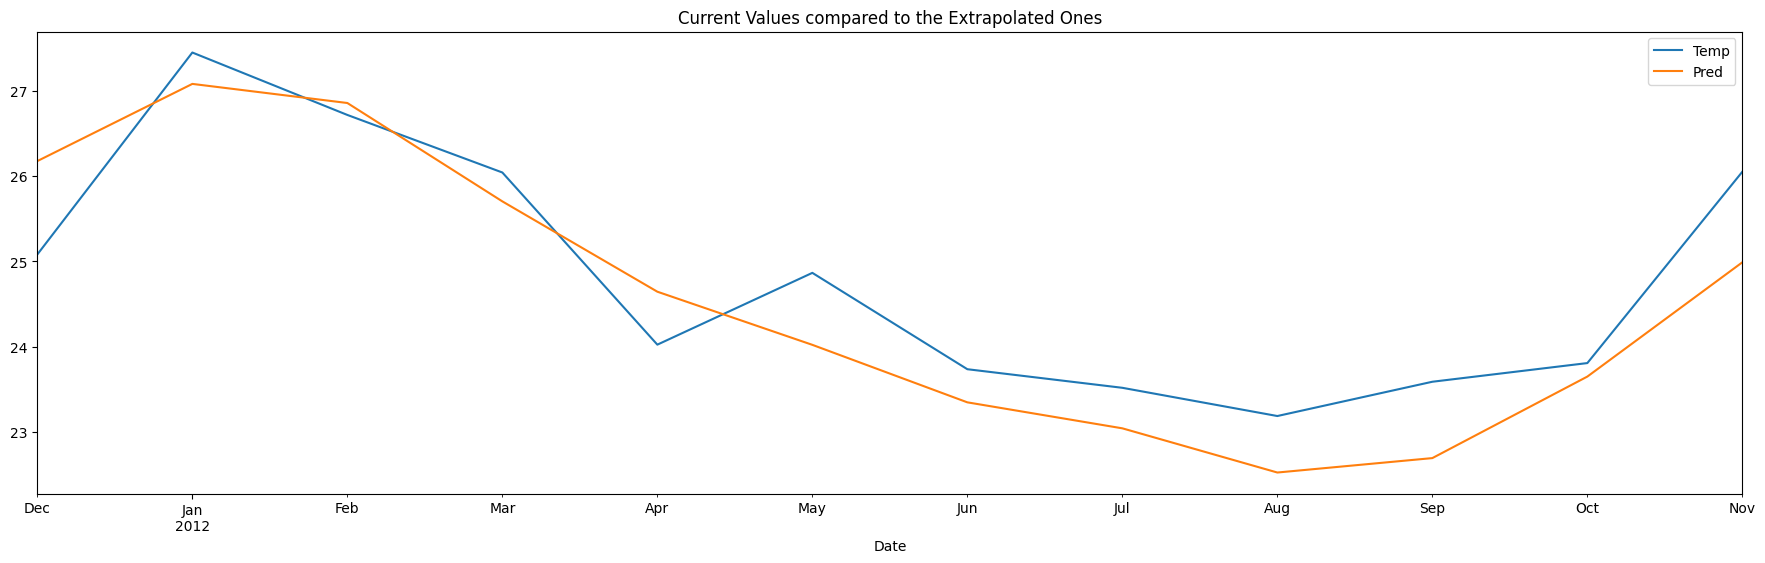

In [46]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

In [47]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 1.23 celsius degrees
The baseline RMSE for the test extrapolation was 0.67 celsius degrees
That is an improvement of 45.64%
